# 1. Install Dependencies and Setup

In [1]:
pip install protobuf==3.20.0

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install tensorflow==2.10.0 opencv-python matplotlib


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
!pip list

Package                      Version
---------------------------- --------
absl-py                      1.4.0
astunparse                   1.6.3
cachetools                   5.3.1
certifi                      2023.5.7
charset-normalizer           3.2.0
contourpy                    1.1.0
cycler                       0.11.0
flatbuffers                  23.5.26
fonttools                    4.40.0
gast                         0.4.0
google-auth                  2.21.0
google-auth-oauthlib         0.4.6
google-pasta                 0.2.0
grpcio                       1.56.0
h5py                         3.9.0
idna                         3.4
keras                        2.10.0
Keras-Preprocessing          1.1.2
kiwisolver                   1.4.4
libclang                     16.0.0
Markdown                     3.4.3
MarkupSafe                   2.1.3
matplotlib                   3.7.2
numpy                        1.25.0
oauthlib                     3.2.2
opencv-python                4.7.0.72
op


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import tensorflow as tf
import os

In [5]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [6]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 2. Remove dodgy images

In [7]:
import cv2
import imghdr

In [8]:
data_dir = '../images/data' 

In [9]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [10]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [11]:
import numpy as np
from matplotlib import pyplot as plt

In [12]:
data = tf.keras.utils.image_dataset_from_directory('../images/data')

Found 2017 files belonging to 4 classes.


In [13]:
data_iterator = data.as_numpy_iterator()

In [14]:
batch = data_iterator.next()

In [15]:
# they give the image numbers based on folder order
# autism images are - 0
# Control Images are - 1
# Parkinson Images are - 2
# Alzheimer images are - 3

batch[1]

array([1, 1, 0, 2, 1, 1, 1, 2, 2, 1, 0, 2, 0, 2, 3, 1, 0, 2, 2, 1, 2, 2,
       2, 1, 3, 2, 3, 2, 2, 2, 1, 1])

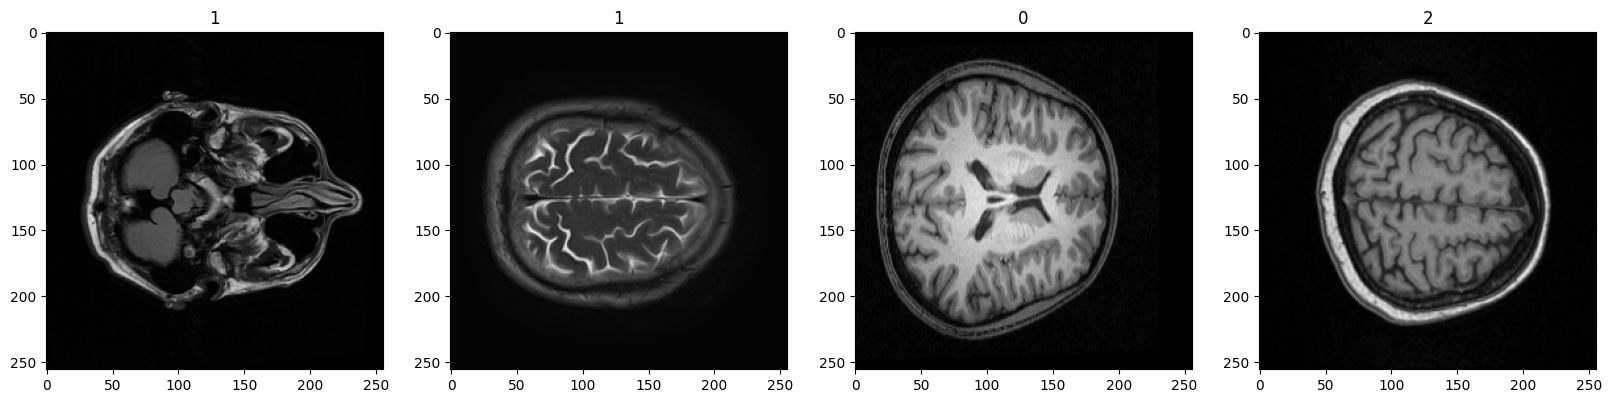

In [16]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [17]:
data = data.map(lambda x,y: (x/255, y))

In [18]:
data.as_numpy_iterator().next()

(array([[[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         ...,
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]],
 
 
        [

# 5. Split Data

In [19]:
len(data)

64

In [20]:
# Images used to train the deep learning model
train_size = int(len(data)*.7)
# Data used to evaluate the model while training
val_size = int(len(data)*.2)+1
# Hold this data out until the end of training to test
test_size = int(len(data)*.1)+1

In [21]:
train_size+val_size+test_size

64

In [22]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [23]:
train

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [25]:
model = Sequential()

In [26]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(4, activation='sigmoid'))

In [27]:
model.compile('adam', loss=tf.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

# 7. Train

In [29]:
logdir='logs'

In [30]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [31]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
44/44 [==============================] - 12s 70ms/step - loss: 0.5958 - accuracy: 0.7514 - val_loss: 0.2246 - val_accuracy: 0.9135
Epoch 2/20
44/44 [==============================] - 3s 64ms/step - loss: 0.1463 - accuracy: 0.9517 - val_loss: 0.0702 - val_accuracy: 0.9760
Epoch 3/20
44/44 [==============================] - 3s 67ms/step - loss: 0.0698 - accuracy: 0.9766 - val_loss: 0.0677 - val_accuracy: 0.9784
Epoch 4/20
44/44 [==============================] - 3s 68ms/step - loss: 0.0206 - accuracy: 0.9972 - val_loss: 0.0427 - val_accuracy: 0.9784
Epoch 5/20
44/44 [==============================] - 3s 66ms/step - loss: 0.0199 - accuracy: 0.9950 - val_loss: 0.0455 - val_accuracy: 0.9904
Epoch 6/20
44/44 [==============================] - 3s 67ms/step - loss: 0.0135 - accuracy: 0.9979 - val_loss: 0.0111 - val_accuracy: 0.9928
Epoch 7/20
44/44 [==============================] - 3s 67ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 8/20
4

# 8. Plot Performance

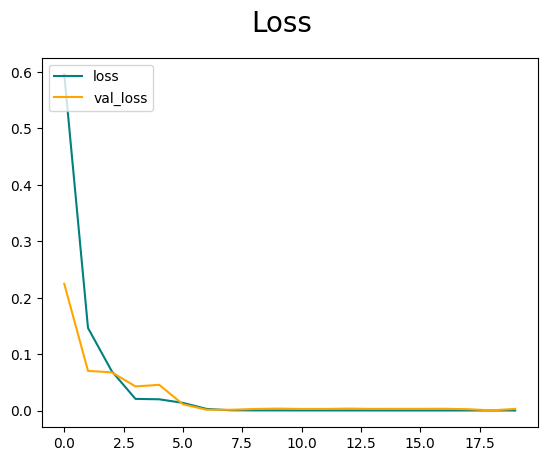

In [32]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

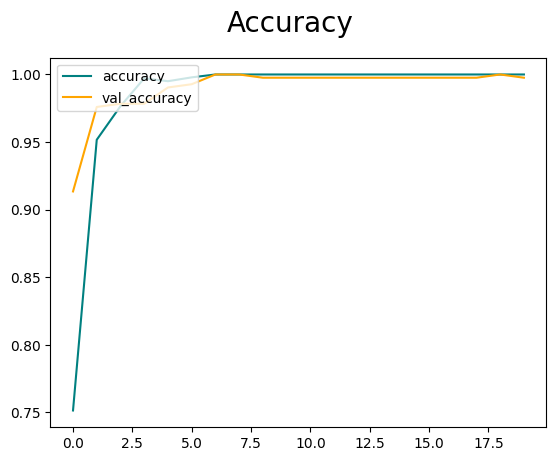

In [33]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [34]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [35]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [36]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
# I get an error once categorical is added
  #  pre.update_state(y, yhat)
# Another error, must not need
  # re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 133ms/step


In [37]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.19170985, shape=(), dtype=float32)


# 10. Test

In [104]:
import cv2

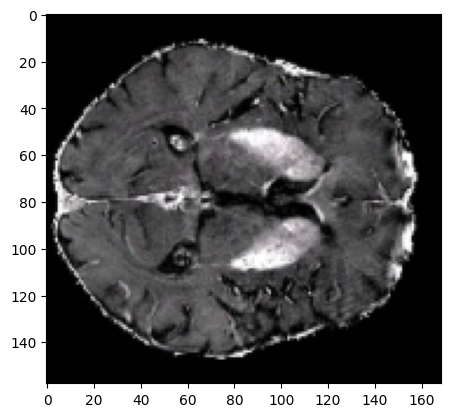

In [111]:
img = cv2.imread('../images/test_scans/google/alzheimer/zimer1.png')
plt.imshow(img)
plt.show()

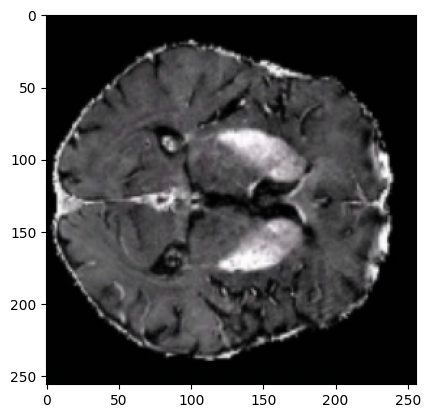

In [112]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [113]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 12ms/step


In [114]:
yhat

array([[9.999999e-01, 7.255397e-01, 5.373951e-05, 9.970028e-01]],
      dtype=float32)

In [115]:
# Accounting for multiple classes
predicted_class = np.argmax(yhat, axis=1)[0]
predicted_class

0

In [116]:
# identifies all autism scans as control and visa versa, even though 0 should be autism and 1 should be control I am flipping them

if predicted_class == 0: 
    print('Predicted class is control')
elif predicted_class == 1:
    print('Predicted class is autism')
elif predicted_class == 2:
    print('Predicted class is parkinson')
else:
    print('Predicted class is alzheimer')

Predicted class is control


# 11. Save the Model

In [51]:
from tensorflow.keras.models import load_model

In [52]:
model.save(os.path.join('models', 'brainclassifier.h5'))

In [53]:
#new_model = load_model('models/imageclassifier.h5') this worked but he updated his in video to the one below
new_model = load_model(os.path.join('models', 'brainclassifier.h5'))
#he also saved an entirely new model with this

In [54]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 63ms/step


array([[0.72557056, 0.61615545, 0.47307152]], dtype=float32)